In [1]:
!pip install catboost
!pip install - q tensorflow == 2.3
!pip install albumentations - q
!pip install pymystem3

     |████████████████████████████████| 320.4 MB 47 kB/s 
     |████████████████████████████████| 2.9 MB 28.6 MB/s 
     |████████████████████████████████| 20.1 MB 1.8 MB/s 
     |████████████████████████████████| 459 kB 37.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.7.0 requires tensorflow-estimator<2.8,~=2.7.0rc0, but you have tensorflow-estimator 2.3.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
from tensorflow.python.client import device_lib
CUDA_VISIBLE_DEVICES = 0
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3016632377909473055
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17294625340634427256
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11119873118389594510
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11142594560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4657674377414615214
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
# загрузка необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import PIL
import random
import nltk
import cv2
import catboost
import pickle

from scipy.stats import ttest_ind, normaltest
from itertools import combinations
import gensim.downloader as api
from PIL import Image

from catboost import CatBoostRegressor
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from pathlib import Path


import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
import albumentations

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tqdm import tqdm
#import pymorphy2
from string import punctuation
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')

RANDOM_SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# функция для получения основной информациии для номинативных переменных

# списки для различных категорий данных
num_cols = []
bin_cols = []
kat_cols = []

# дополнительные функции для анализа данных


def info_kat(data, col):
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Количество уникальных значений:', data[col].nunique())
    display(data[col].value_counts())
    sns.countplot(y=col, data=data)


def bin_kat(data, col):
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Количество уникальных значений:', data[col].nunique())
    display(data[col].value_counts())
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))
    sns.countplot(x=col, data=data, ax=ax[0])


def num_kat(data, col):
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Основная статистика:')
    display(data[col].describe())
    data[col].hist()


# функция для исследония данных на выбросы
def vubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    df = pd.Series(x).loc[pd.Series(x).between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    plt.hist(df, bins=10, range=(0, (perc75 + 1.5*IQR)*1.2), label='IQR')
    plt.legend()


# функция, возвращающая границы для удаления выбросов
def interval_vubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    return(f, l)

# Реализуем функцию для вычисления NAPE


def MAPE_score(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

# EDA

# Типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train['train'] = 1
test['train'] = 0

test['price'] = 0
data_all = pd.concat([train, test])
data_al = pd.concat([train, test])
data_all.reset_index(inplace=True)
data_all.tail()

,index,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train
8348,1666,седан,BMW,коричневый,Продаётся любимица семьи. Автомобилем неактивн...,2.0 LTR,184 N12,бензин,76000,2011,3ER,320i 2.0 AT (184 л.с.),4,0.0,2012,1099414488,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,7 лет,Оригинал,задний,Левый,0
8349,1667,внедорожник 5 дв.,BMW,синий,"В продаже автомобиль от компании АО ABTODOM, о...",3.0 LTR,218 N12,дизель,120381,2013,X5,25d 3.0d AT (218 л.с.) 4WD,5,0.0,2017,1099277058,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0
8350,1668,внедорожник 5 дв.,AUDI,белый,Машина в идеальном техническом состоянии. Обсл...,1.4 LTR,150 N12,бензин,25790,2014,Q3,1.4 AMT (150 л.с.),5,0.0,2016,1098773964,ALLROAD_5_DOORS ROBOT 1.4,роботизированная,2 владельца,3 года и 3 месяца,Оригинал,передний,Левый,0
8351,1669,седан,BMW,белый,Автомобиль приобретался новым у дилера Avilon ...,2.0 LTR,184 N12,бензин,104000,2009,5ER,520i 2.0 AT (184 л.с.),4,0.0,2013,1098835932,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,6 лет и 10 месяцев,Оригинал,задний,Левый,0
8352,1670,седан,AUDI,чёрный,ID: 38887\nКомплектация-Comfort\nГод выпуска в...,2.0 LTR,225 N12,бензин,112434,2011,A4,2.0 AMT (225 л.с.) 4WD,4,0.0,2014,1099834690,SEDAN ROBOT 2.0,роботизированная,3 или более,NaN,Дубликат,полный,Левый,0


Посмотрим на общую статистику данных и пропущенных значений

In [6]:
# для числовых признаков
data_all.describe()

,index,mileage,modelDate,numberOfDoors,price,productionDate,sell_id,train
count,8353.000000,8353.000000,8353.000000,8353.000000,8.353000e+03,8353.000000,8.353000e+03,8353.000000
mean,2839.280019,120362.983479,2010.103556,4.262062,1.519804e+06,2012.010775,1.096591e+09,0.799952
std,2006.999233,81856.639133,5.436914,0.885531,1.873130e+06,5.107314,2.657545e+07,0.400060
min,0.000000,1.000000,1971.000000,2.000000,0.000000e+00,1982.000000,3.421294e+07,0.000000
25%,1044.000000,59246.000000,2007.000000,4.000000,4.600000e+05,2009.000000,1.097086e+09,1.000000
50%,2505.000000,110384.000000,2011.000000,4.000000,1.030000e+06,2013.000000,1.099407e+09,1.000000
75%,4593.000000,167084.000000,2014.000000,5.000000,1.900000e+06,2016.000000,1.099975e+09,1.000000
max,6681.000000,1000000.000000,2019.000000,5.000000,2.390000e+07,2020.000000,1.100273e+09,1.000000


In [7]:
data_all.isnull().sum()

index                      0
bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
train                      0
dtype: int64

## BodyType

Количество пропущенных значений: 0
Количество уникальных значений: 17


седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

None

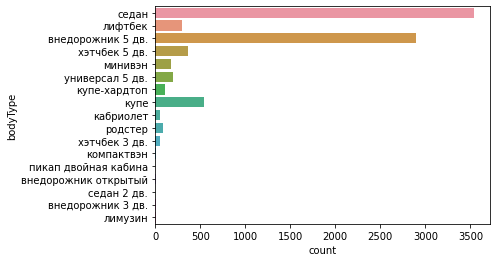

In [8]:
display(info_kat(data_all, 'bodyType'))

Посмотрим на корреляцию значений между <code>bodyType</code> и <code>numberOfDoors</code>

In [9]:
pd.crosstab(train.bodyType, train.numberOfDoors, dropna=False)

numberOfDoors,2,3,4,5
bodyType,,,,
внедорожник 3 дв.,0,3,0,0
внедорожник 5 дв.,0,0,0,2315
внедорожник открытый,2,0,0,0
кабриолет,44,0,0,0
компактвэн,0,0,0,8
купе,427,0,0,0
купе-хардтоп,91,0,0,0
лимузин,0,0,5,0
лифтбек,0,0,0,245


Видно по таблице, что каждый тип кузова представлен единственным количеством дверей, кроме хэтчбек 3 двери, очевидно, что это ошибка пользователя, который вводил такие данные в объявление. Таким образом, признак numberOfDoors является избыточным, поэтому удалим его из датасета.

## Brand 

Количество пропущенных значений: 0
Количество уникальных значений: 3


BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

None

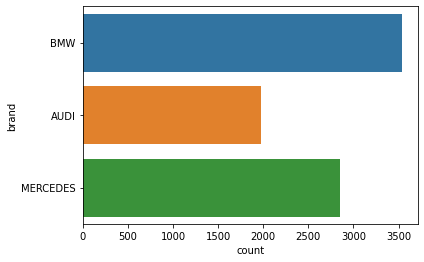

In [10]:
display(info_kat(data_all, 'brand'))

Посмотрим на распределение значений между <code>brand</code> и <code>model_info</code>

In [11]:
display(pd.crosstab(train.model_info, train.brand, dropna=False)[:20])

brand,AUDI,BMW,MERCEDES
model_info,,,
100,1,0,0
1ER,0,141,0
2ACTIVETOURER,0,3,0
2ER,0,8,0
2GRANDTOURER,0,4,0
3ER,0,466,0
4,0,53,0
5ER,0,611,0
6ER,0,76,0


Очевидно, что модель уникальна для каждого бренда, поэтому переменная бренд является избыточной и будет удалена из обучающего датасета.

## Color 

Количество пропущенных значений: 0
Количество уникальных значений: 16


чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

None

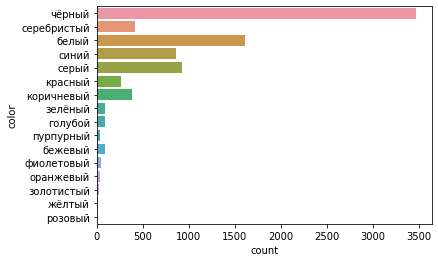

In [12]:
display(info_kat(data_all, 'color'))

Видим, что значения корректны, отсутствующих значений нет, дополнительной предобработки признак не нуждается

## Description 

Дескрипшен представляет собой описание автомобиля пользователя, в catboost не будет его использовать.

In [13]:
data_all.iloc[0]['description']

'Авто на бодром ходу.  Все работает отлично.  По электрике,ходовой.,АКПП ДВС нареканий нет..,   Масло не ест. .!!!Салон ухожен. На запчасти денег не жалел. Жидкости все поменял. Крашена одна дверь левая задняя. Штрафов и ограничений нет. ..!  Торг при осмотре. Возможен обмен на внедорожник или коммерческий транспорт. '

## engineDisplacement 

In [14]:
data_all['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
3.1 LTR            44
2.4 LTR            44
6.2 LTR            40
6.0 LTR            37
1.2 LTR            33
5.4 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
0.7 LTR             6
undefined LTR       6
5.8 LTR             5
4.6 LTR             5
1.9 LTR             5
6.6 LTR             5
3.4 LTR             4
4.3 LTR             4
6.3 LTR             3
5.6 LTR   

In [15]:
# Функция, чтобы достать числовие значения из признака
def change_function(row):
    result = re.match(r'\d\.\d', row)
    if result != None:
        return result.group(0)
    else:
        return 0

In [16]:
data_all['engineDisplacement'] = data_all['engineDisplacement'].apply(
    change_function)

# Проверяем количество пустых строк
data_all[data_all['engineDisplacement'].isnull()]

,index,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train


Количество пропущенных значений: 0
Основная статистика:


count    8353.000000
mean        2.777445
std         1.058259
min         0.000000
25%         2.000000
50%         2.800000
75%         3.000000
max         6.600000
Name: engineDisplacement, dtype: float64

None

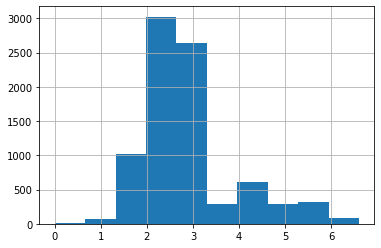

In [17]:
data_all['engineDisplacement'] = data_all['engineDisplacement'].astype(float)
display(num_kat(data_all, 'engineDisplacement'))

## enginePower

In [18]:
data_all['enginePower'].head(10)

0    272 N12
1    204 N12
2    306 N12
3    180 N12
4    160 N12
5    184 N12
6    197 N12
7    326 N12
8    190 N12
9    184 N12
Name: enginePower, dtype: object

In [19]:
# Функция, чтобы достать числовие значения из признака - количество лошадиных сил
def change_function2(row):
    result = re.match(r'\d\d\d', row)
    if result != None:
        return int(result.group(0))
    else:
        return np.nan


data_all['enginePower'] = data_all['enginePower'].apply(change_function2)

Количество пропущенных значений: 12
Основная статистика:


count    8341.000000
mean      255.801702
std       108.774970
min       100.000000
25%       184.000000
50%       231.000000
75%       306.000000
max       700.000000
Name: enginePower, dtype: float64

None

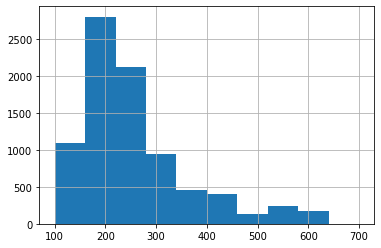

In [20]:
display(num_kat(data_all, 'enginePower'))

In [21]:
data_all['enginePower'].fillna(data_all['enginePower'].min(), inplace=True)

In [22]:
# Прологорифмируем признак, чтобы привести его к нормальному закону
data_all['enginePower'] = data_all['enginePower'].apply(lambda x: np.log(x))

## fuelType

Количество пропущенных значений: 0
Количество уникальных значений: 4


бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

None

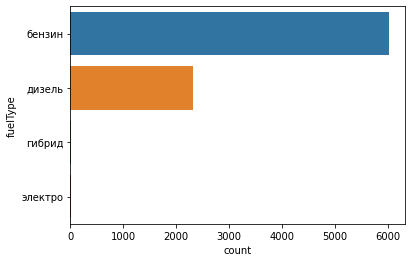

In [23]:
display(info_kat(data_all, 'fuelType'))

## mileage

In [24]:
data_all['mileage'].head(10)

0    245000
1    183000
2    122733
3    151000
4    140000
5    229000
6        50
7     90000
8     87000
9    171644
Name: mileage, dtype: int64

Количество пропущенных значений: 0
Основная статистика:


count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64

None

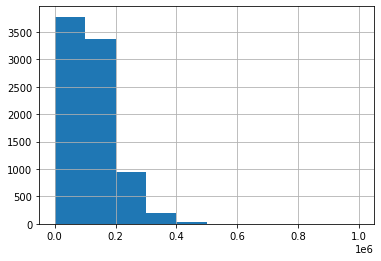

In [25]:
display(num_kat(data_all, 'mileage'))

25-й перцентиль: 59246.0, 75-й перцентиль: 167084.0, IQR: 107838.0,  Границы выбросов: [-102511.0, 328841.0].


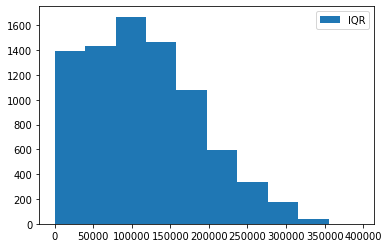

In [26]:
vubros(data_all['mileage'])

In [27]:
# Посмотрим сколько машин, имеют пробег больше 341900 км
data_all[(data_all['mileage'] > 328841)].shape[0]

161

In [28]:
# Прологорифмируем признак, чтобы привести его к нормальному закону
data_all['mileage'] = data_all['mileage'].apply(lambda x: np.log(x))

## modelDate

Количество пропущенных значений: 0
Основная статистика:


count    8353.000000
mean     2010.103556
std         5.436914
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

None

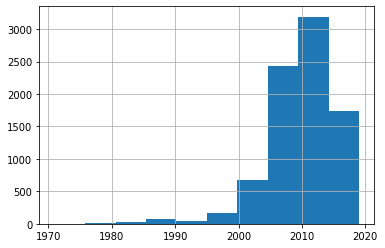

In [29]:
display(num_kat(data_all, 'modelDate'))

In [30]:
# Прологорифмируем признак, чтобы привести его к нормальному закону
data_all['modelDate'] = data_all['modelDate'].apply(lambda x: np.log(x))

## model_info

Количество пропущенных значений: 0
Количество уникальных значений: 122


5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
W123          1
Z3M           1
100           1
Z1            1
Z8            1
Name: model_info, Length: 122, dtype: int64

None

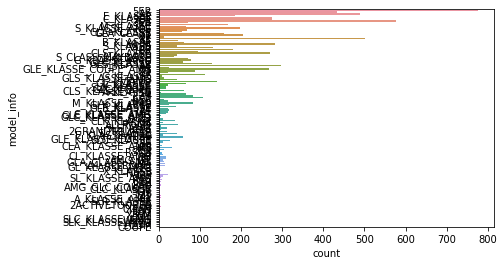

In [31]:
display(info_kat(data_all, 'model_info'))

## name 

Количество пропущенных значений: 0
Количество уникальных значений: 976


35i 3.0 AT (306 л.с.) 4WD               151
2.0 AMT (211 л.с.) 4WD                  145
200 2.0 AT (184 л.с.)                   137
30d 3.0d AT (249 л.с.) 4WD              109
400 3.0 AT (333 л.с.) 4WD                97
                                       ... 
535i 3.4 AT (211 л.с.)                    1
1.9 AT (140 л.с.)                         1
3.0 MT (286 л.с.)                         1
528i 2.8 AT (193 л.с.)                    1
300 d длинный 2.0d AT (239 л.с.) 4WD      1
Name: name, Length: 976, dtype: int64

None

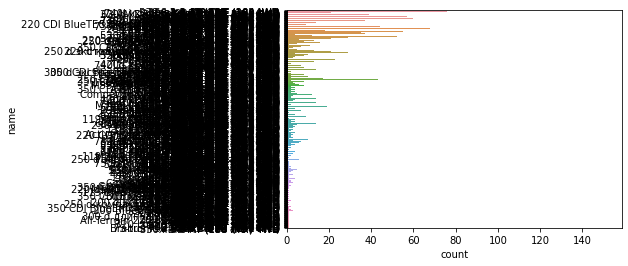

In [32]:
display(info_kat(data_all, 'name'))

Данные признак содержит в себе информацию других признаков таких как  'engineDisplacement', 'enginePower',   'vehicleTransmission', 'Привод'. Поэтому нет смысла его оставлять.

## price

Количество пропущенных значений: 0
Основная статистика:


count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64

None

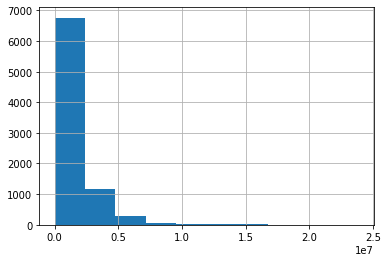

In [33]:
display(num_kat(data_all, 'price'))

In [34]:
# Прологорифмируем переменную, чтобы привести к нормальному закону
data_all['price'] = data_all['price'].apply(lambda x: np.log(x))

## productionDate

Количество пропущенных значений: 0
Основная статистика:


count    8353.000000
mean     2012.010775
std         5.107314
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

None

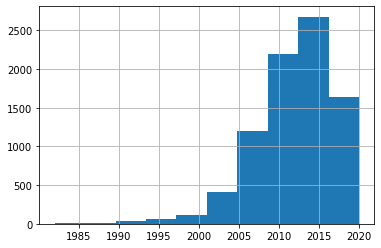

In [35]:
data_all['productionDate'] = data_all['productionDate'].astype(int)
display(num_kat(data_all, 'productionDate'))

In [36]:
# Прологорифмируем переменную, чтобы привести к нормальному закону
data_all['productionDate'] = data_all['productionDate'].apply(
    lambda x: np.log(x))

## vehicleTransmission

Количество пропущенных значений: 0
Количество уникальных значений: 4


автоматическая      6560
роботизированная    1201
вариатор             406
механическая         186
Name: vehicleTransmission, dtype: int64

None

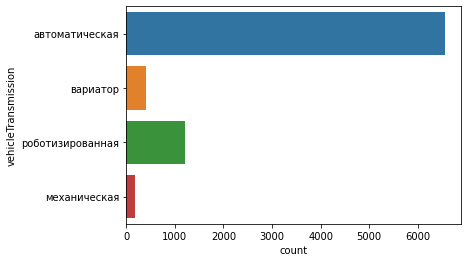

In [37]:
display(info_kat(data_all, 'vehicleTransmission'))

## Владельцы

Количество пропущенных значений: 1
Количество уникальных значений: 3


3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

None

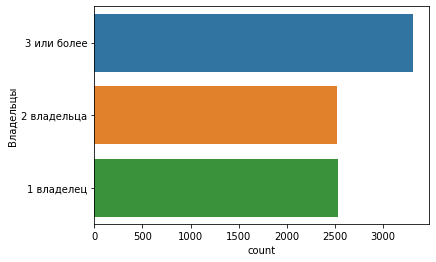

In [38]:
display(info_kat(data_all, 'Владельцы'))

## Владение

Количество пропущенных значений: 5418
Количество уникальных значений: 180


1 год и 8 месяцев      67
1 год и 2 месяца       67
1 год                  55
1 год и 10 месяцев     52
9 месяцев              52
                       ..
27 лет и 10 месяцев     1
21 год и 5 месяцев      1
19 лет                  1
14 лет и 1 месяц        1
14 лет и 5 месяцев      1
Name: Владение, Length: 180, dtype: int64

None

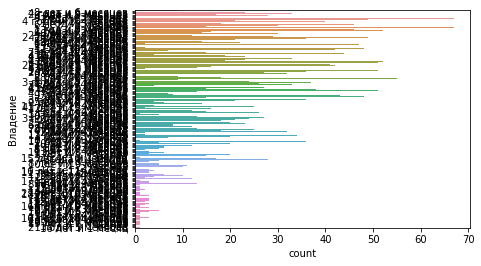

In [39]:
display(info_kat(data_all, 'Владение'))

Количество пропущенных значений очень велико, удалим данный столбец.

## ПТС

Количество пропущенных значений: 0
Количество уникальных значений: 2


Оригинал    7474
Дубликат     879
Name: ПТС, dtype: int64

None

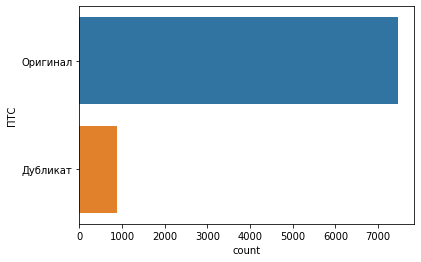

In [40]:
display(info_kat(data_all, 'ПТС'))

##  Привод

Количество пропущенных значений: 0
Количество уникальных значений: 3


полный      5218
задний      2259
передний     876
Name: Привод, dtype: int64

None

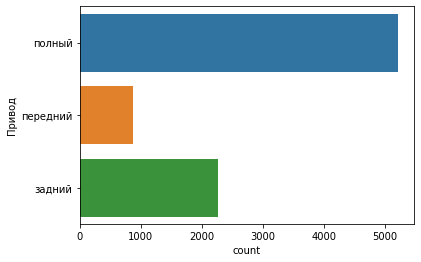

In [41]:
display(info_kat(data_all, 'Привод'))

## Руль

Количество пропущенных значений: 0
Количество уникальных значений: 2


Левый     8351
Правый       2
Name: Руль, dtype: int64

None

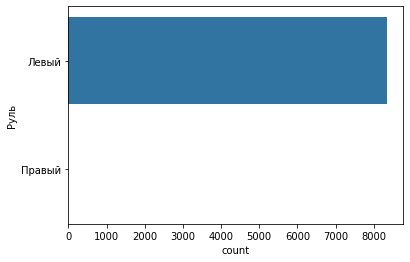

In [42]:
display(info_kat(data_all, 'Руль'))

# Предобработка данных

In [43]:
# удаление избыточных признаков
cols = ['numberOfDoors', 'brand', 'description', 'index', 'name',
        'sell_id', 'vehicleConfiguration', 'Владение', 'Руль']
data_all.drop(cols, inplace=True, axis=1)
data_all.columns

Index(['bodyType', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
       'mileage', 'modelDate', 'model_info', 'price', 'productionDate',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'train'],
      dtype='object')

## Числовые признаки

Числовые признаки необходимо нормализовать

In [44]:
num_cols = [
    'modelDate',
    'productionDate',
    'engineDisplacement',
    'enginePower',
    'mileage',
    'price'
]

In [45]:
data_all[num_cols].isnull().sum()

modelDate             0
productionDate        0
engineDisplacement    0
enginePower           0
mileage               0
price                 0
dtype: int64

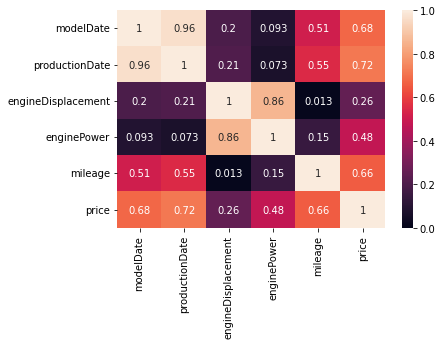

In [46]:
sns.heatmap(data_all[num_cols].corr().abs(), annot=True, vmin=0, vmax=1)

Некоторые признаки сильно скоррелированы, например дата модели и дата производства машин, что является логичным. На целевой признак price, значительно влияют - дата модели, дата производства машины, пробег

In [47]:
# Нормализуем данные
num_cols = [
    'modelDate',
    'productionDate',
    'engineDisplacement',
    'enginePower',
    'mileage'
]
mask = (data_all['train'] == 1)
# df_scaler=pd.DataFrame(columns=num_cols)
scaler = StandardScaler()
scaler.fit(data_all[mask][num_cols])
df_scaler = pd.DataFrame(scaler.transform(
    data_all[num_cols]), columns=num_cols)
df_scaler.head()

,modelDate,productionDate,engineDisplacement,enginePower,mileage
0,-0.581881,-0.995034,0.204789,0.363008,0.846839
1,0.161957,-0.202801,0.016770,-0.391623,0.623781
2,-0.209777,0.192724,0.674837,0.671970,0.318384
3,0.161957,-0.202801,-0.735306,-0.719944,0.476840
4,-0.581881,-0.202801,-0.923325,-1.028906,0.419016


## Категориальные признаки

In [48]:
cat_cols = [
    'bodyType',
    'color',
    'fuelType',
    'vehicleTransmission',
    'Привод',
    'Владельцы',
    'ПТС',
    'model_info'
]
# Проверим значимость признаков


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='price',
                data=train.loc[train.loc[:, column].isin(
                    train.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

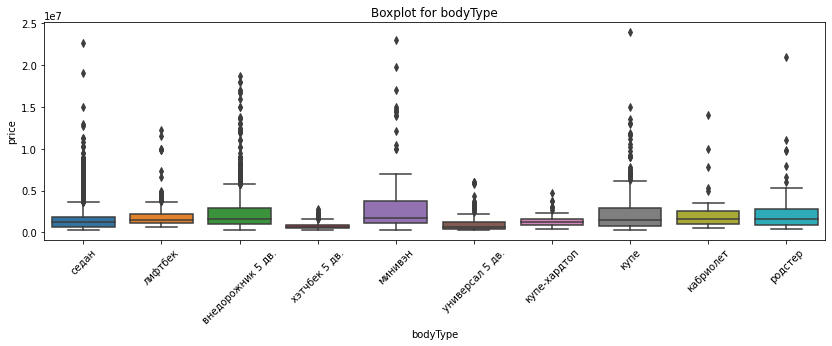

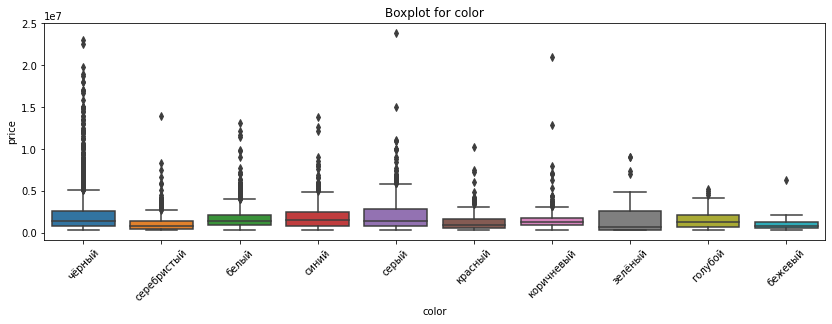

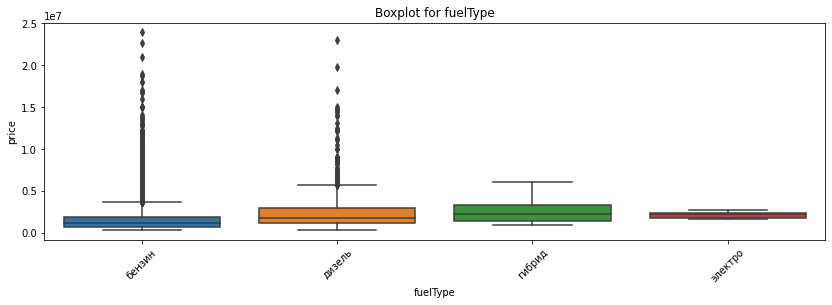

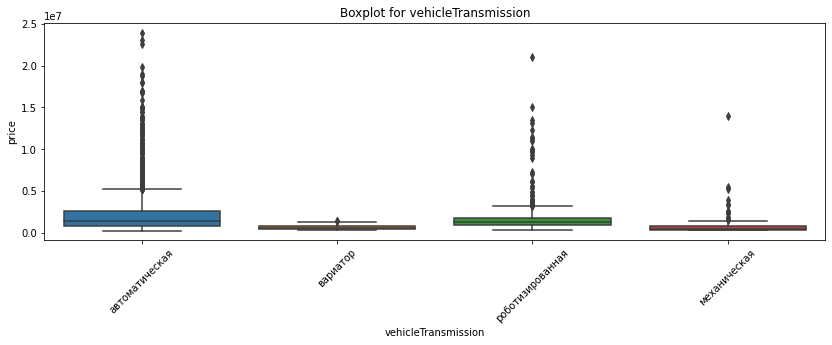

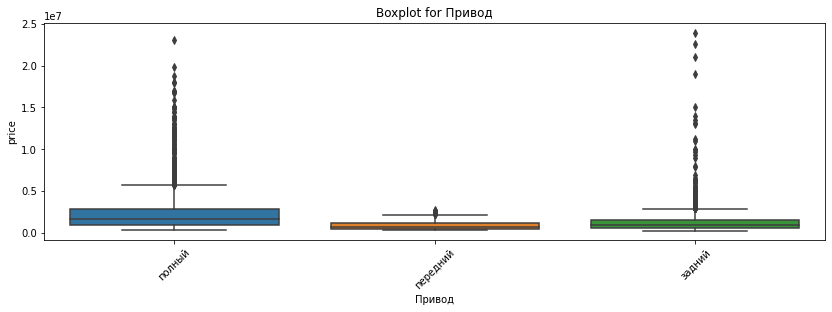

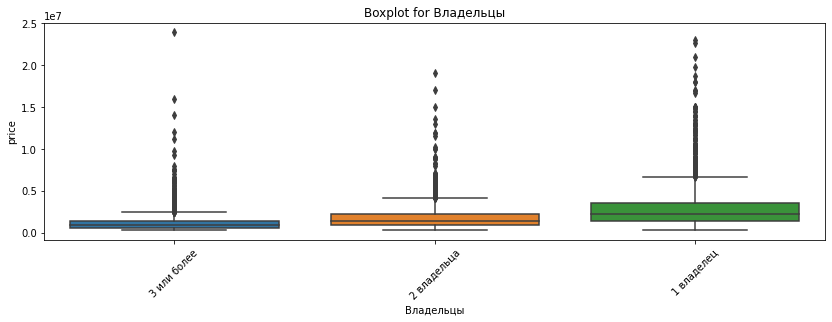

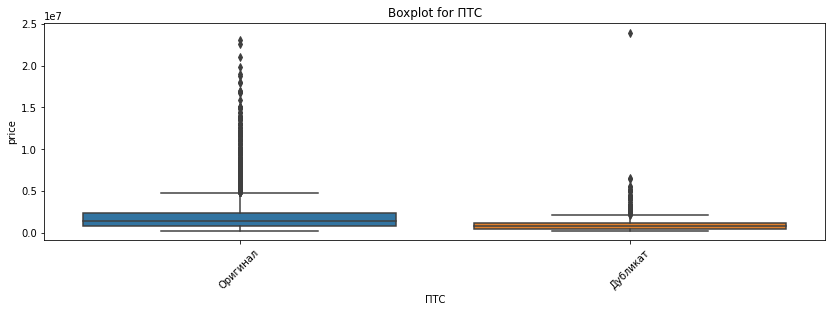

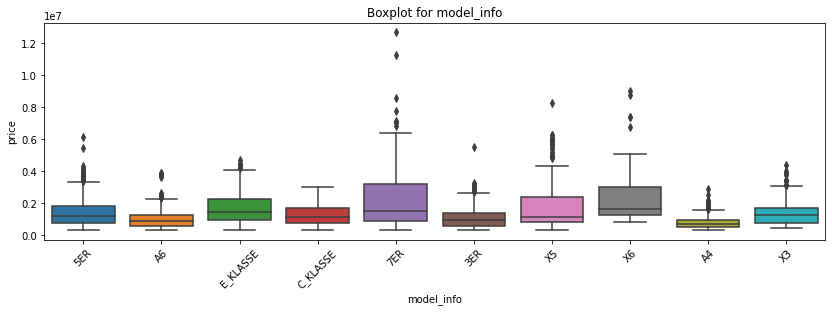

In [49]:
for col in cat_cols:
    get_boxplot(col)

In [50]:
def get_stat_dif(column):
    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'],
                     train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки - ', column)
            break
        else:
            print('Cтатистически незначимые различия для колонки - ', column)
            break

In [51]:
for col in cat_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки -  bodyType
Найдены статистически значимые различия для колонки -  color
Найдены статистически значимые различия для колонки -  fuelType
Найдены статистически значимые различия для колонки -  vehicleTransmission
Найдены статистически значимые различия для колонки -  Привод
Найдены статистически значимые различия для колонки -  Владельцы
Найдены статистически значимые различия для колонки -  ПТС
Найдены статистически значимые различия для колонки -  model_info


In [52]:
# Исходя из исследований статистически не значимым является признак Руль, поэтому он был удален
data_cat = data_all[cat_cols]
dummy_features = pd.get_dummies(data_cat)
# df_scaler.drop(columns=data_cat,inplace=True,axis=1)

df_scaler_dummy = pd.concat([df_scaler, dummy_features], axis=1)
df_scaler_dummy[['price', 'train']] = data_all[['price', 'train']]
df_scaler_dummy = pd.concat([df_scaler_dummy, data_all[bin_cols]], axis=1)

# Catboost

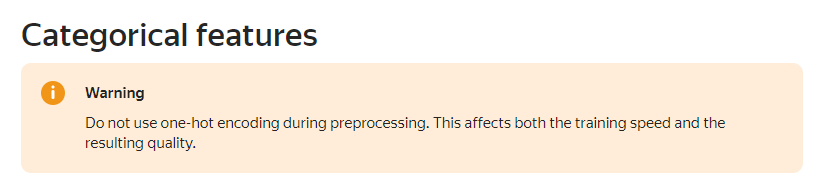

https://catboost.ai/en/docs/features/categorical-features

In [53]:
# Снова загружаем данные, исходя из документации, нет необходимости конвертировать категориальные
# признаки, также т.к. в основе лежат деревья решений, то и нормализацию можно не использовать

train_cat = pd.read_csv('train.csv')
test_cat = pd.read_csv('test.csv')

# удалим избыточные признаки
cols = ['numberOfDoors', 'brand', 'description', 'sell_id',
        'name', 'vehicleConfiguration', 'Владение', 'Руль']
train_cat.drop(cols, inplace=True, axis=1)
test_cat.drop(cols, inplace=True, axis=1)

# преодобработаем с учетом вышесделанного EDA, без one-hot encoding, и нормализации,
# используем функции, которые определены в каждом пункте каждого признака
train_cat['enginePower'] = train_cat['enginePower'].apply(change_function2)
test_cat['enginePower'] = test_cat['enginePower'].apply(change_function2)

train_cat['engineDisplacement'] = train_cat['engineDisplacement'].apply(
    change_function)
test_cat['engineDisplacement'] = test_cat['engineDisplacement'].apply(
    change_function)

train_cat['enginePower'].fillna(train_cat['enginePower'].min(), inplace=True)
test_cat['enginePower'].fillna(train_cat['enginePower'].min(), inplace=True)

train_cat['Владельцы'].fillna('None', inplace=True)
test_cat['Владельцы'].fillna('None', inplace=True)

train_cat['price'] = train_cat['price'].apply(lambda x: np.log(x))

X_cat = train_cat.drop(['price'], axis=1)
Y_cat = train_cat['price']

In [54]:
X, X_test, y, y_test = train_test_split(
    X_cat, Y_cat, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [55]:
# Реализуем функцию для вычисления NAPE
def MAPE_score(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [56]:
X.head()

,bodyType,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,productionDate,vehicleTransmission,Владельцы,ПТС,Привод
5649,седан,белый,6.0,544.0,бензин,150000,2008,7ER,2011,автоматическая,1 владелец,Оригинал,задний
6366,внедорожник 5 дв.,синий,2.0,245.0,бензин,20942,2016,GLC_COUPE,2018,автоматическая,1 владелец,Оригинал,полный
3010,седан,чёрный,3.1,255.0,бензин,133897,2004,A6,2006,автоматическая,3 или более,Оригинал,полный
4343,седан,серый,1.8,184.0,бензин,330000,2006,E_KLASSE,2007,автоматическая,3 или более,Оригинал,задний
1978,седан,белый,3.0,313.0,дизель,126000,2011,6ER,2013,автоматическая,1 владелец,Оригинал,полный


In [57]:
categorical_indices = [0, 1, 4, 7, 9, 10, 11, 12]
cat_boost = catboost.CatBoostRegressor(
    depth=7, learning_rate=0.1, silent=True, cat_features=categorical_indices, eval_metric='MAPE', random_seed=RANDOM_SEED)
cat_boost.fit(X, y)

print(
    f"TRAIN mape: {(MAPE_score(np.exp(y), np.exp(cat_boost.predict(X))))*100:0.2f}%")

TRAIN mape: 8.58%


In [58]:
test_predict_catboost = cat_boost.predict(X_test)
print(
    f"TEST mape: {(MAPE_score(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.60%


In [59]:
sub_predict_catboost = np.exp(cat_boost.predict(test_cat))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

In [60]:
sample_submission['price'].head()

0    5.748889e+05
1    2.310738e+06
2    6.270077e+05
3    4.952691e+05
4    2.687446e+06
Name: price, dtype: float64

Результаты:

1.   Не предобрабатывались категориальные признаки в on-hot encoding, т.к. предупреждение в документации catboost.
1.   Для обработки остальных признаков использовался вышепреведенный EDA
1.   Был прологорифмирован таргет, показал лучше результаты, чем в исходном виде.






# Tabular NN

Построим обычную сеть:

In [61]:
df_scaler_dummy.head()

,modelDate,productionDate,engineDisplacement,enginePower,mileage,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_универсал 5 дв.,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 5 дв.,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_бензин,fuelType_гибрид,...,model_info_SLC_KLASSE,model_info_SLC_KLASSE_AMG,model_info_SLK_KLASSE,model_info_SLK_KLASSE_AMG,model_info_SLR_KLASSE,model_info_SLS_AMG,model_info_SL_KLASSE,model_info_SL_KLASSE_AMG,model_info_SQ5,model_info_SQ7,model_info_S_CLASS_MAYBACH,model_info_S_KLASSE,model_info_S_KLASSE_AMG,model_info_TT,model_info_TTS,model_info_VIANO,model_info_VITO,model_info_V_KLASSE,model_info_W123,model_info_W124,model_info_W201,model_info_X1,model_info_X2,model_info_X3,model_info_X3_M,model_info_X4,model_info_X4_M,model_info_X5,model_info_X5_M,model_info_X6,model_info_X6_M,model_info_X7,model_info_X_KLASSE,model_info_Z1,model_info_Z3,model_info_Z3M,model_info_Z4,model_info_Z8,price,train
0,-0.581881,-0.995034,0.204789,0.363008,0.846839,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.303017,1
1,0.161957,-0.202801,0.016770,-0.391623,0.623781,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.652992,1
2,-0.209777,0.192724,0.674837,0.671970,0.318384,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.096923,1
3,0.161957,-0.202801,-0.735306,-0.719944,0.476840,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.610943,1
4,-0.581881,-0.202801,-0.923325,-1.028906,0.419016,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.604790,1


In [62]:
X_train_normal = df_scaler_dummy[df_scaler_dummy['train'] == 1].drop(
    ['price', 'train'], axis=1)
y_train_normal = df_scaler_dummy[df_scaler_dummy['train'] == 1]['price']

X_sub = df_scaler_dummy[df_scaler_dummy['train']
                        == 0].drop(['price', 'train'], axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_normal, y_train_normal, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Simple Dense NN

In [64]:
# Архитектура модели
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dense(1000, activation="relu"))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dense(1, activation="linear"))

In [65]:
model.compile(loss='MAPE', optimizer=Adam(1e-2), metrics=['MAPE'])

In [66]:
checkpoint = ModelCheckpoint(
    'best_model.hdf5', monitor='val_MAPE',
    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [67]:
history = model.fit(X_train, np.exp(y_train),
                    batch_size=512,
                    epochs=500,
                    validation_data=(X_test, np.exp(y_test)),
                    callbacks=callbacks_list,
                    verbose=0,
                    )

In [68]:
model.load_weights('best_model.hdf5')
model.save('dense_nn.hdf5')

predict_densenn = model.predict(X_test)
print(
    f"TEST mape: {(MAPE_score(np.exp(y_test), predict_densenn[:,0]))*100:0.2f}%")

TEST mape: 10.86%


In [69]:
predict_dense = model.predict(X_sub)
sample_submission['price'] = predict_dense[:, 0]
sample_submission.to_csv('dense.csv', index=False)

In [70]:
predict_densenn

array([[ 611429.3 ],
       [ 928432.8 ],
       [1215555.  ],
       ...,
       [ 571446.3 ],
       [ 945461.94],
       [ 976948.25]], dtype=float32)

Результаты: путем небольших изменений архитектуры удалось получить значительно лучшего качества.


# Model 4: NLP + Multiple Inputs

In [71]:
# TOKENIZER
# максимальное количество слов использовано
MAX_WORDS = 100000
# максимальное количество слов в строке
MAX_SEQUENCE_LENGTH = 256

In [72]:
df_preproc = pd.DataFrame({'description_preproc': data_al['description']})

In [73]:
# %%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_preproc.description_preproc)
# tokenize.word_index

In [74]:
# split данных
text_train = df_preproc.description_preproc.iloc[X_train.index]
text_test = df_preproc.description_preproc.iloc[X_test.index]
text_sub = df_preproc.description_preproc.iloc[X_sub.index]

# %%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


### RNN NLP

In [75]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(512, return_sequences=True))
model_nlp.add(L.Dense(256, activation="relu"))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dense(128, activation="relu"))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [76]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dense(1000, activation="relu"))
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dense(256, activation="relu"))

In [77]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

# Fit

In [78]:
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [79]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)

callbacks_list = [checkpoint, earlystop]

In [80]:
history = model.fit([text_train_sequences, X_train], np.exp(y_train),
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(
                        [text_test_sequences, X_test], np.exp(y_test)),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 14s 1s/step - loss: 111.1844 - MAPE: 111.1844 - val_loss: 64.4135 - val_MAPE: 64.4135
Epoch 2/500
12/12 [==============================] - 12s 1s/step - loss: 47.1100 - MAPE: 47.1100 - val_loss: 28.8686 - val_MAPE: 28.8686
Epoch 3/500
12/12 [==============================] - 12s 1s/step - loss: 26.1729 - MAPE: 26.1729 - val_loss: 24.1602 - val_MAPE: 24.1602
Epoch 4/500
12/12 [==============================] - 13s 1s/step - loss: 19.2493 - MAPE: 19.2493 - val_loss: 20.3846 - val_MAPE: 20.3846
Epoch 5/500
12/12 [==============================] - 12s 1s/step - loss: 16.0469 - MAPE: 16.0469 - val_loss: 15.3932 - val_MAPE: 15.3932
Epoch 6/500
12/12 [==============================] - 12s 1s/step - loss: 14.1383 - MAPE: 14.1383 - val_loss: 13.3617 - val_MAPE: 13.3617
Epoch 7/500
12/12 [==============================] - 12s 1s/step - loss: 13.6033 - MAPE: 13.6033 - val_loss: 16.7957 - val_MAPE: 16.7957
Epoch 8/500
12/12 [====================

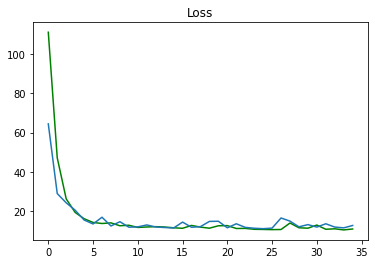

In [81]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train', color='green')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [82]:
model.load_weights('best_model.hdf5')
model.save('mlpnlp_model.hdf5')

In [83]:
test_predict_nn2 = model.predict([text_test_sequences, (X_test)])
print(
    f"TEST mape: {(MAPE_score(np.exp(y_test), test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.59%


Была изменена архитектура для nlp модели, также добавилась learning rate function.

### Добавляем картинки

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


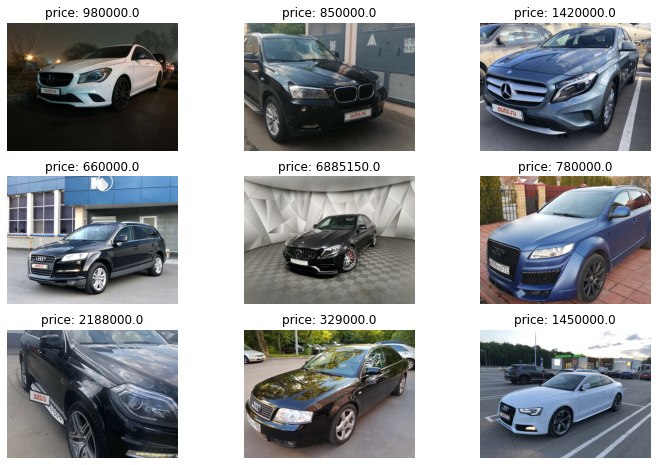

In [85]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))
DATA_DIR = 'drive/MyDrive'
random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [86]:
size = (320, 240)


def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data_al['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + '/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(sample_submission.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


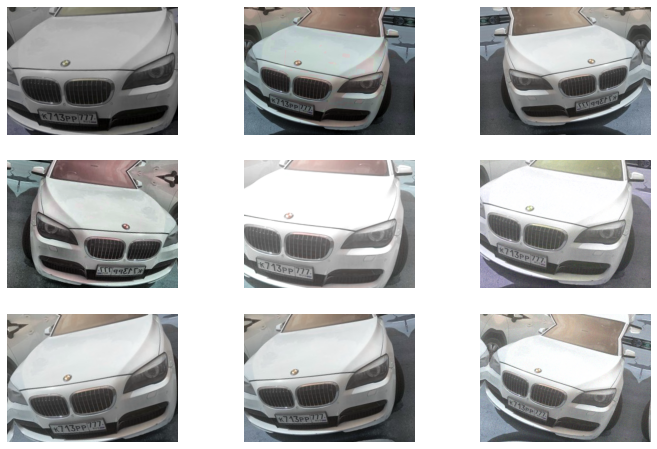

In [87]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


# пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
                     rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [88]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [89]:
# TOKENIZER
# максимальное количество слов использовано
MAX_WORDS = 100000
# максимальное количество слов в строке
MAX_SEQUENCE_LENGTH = 256

# Лемматизируем и удалим стоп слова
mystem = Mystem()
russian_stopwords = stopwords.words("russian")


def preprocess_text(text):
    """функция для предобработки текста"""
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords
              and token != " "
              and token.strip() not in punctuation]
    text = " ".join(tokens)

    return text


#df_preproc['description_preproc'] = data['description'].apply(preprocess_text)
df_preproc['description_preproc'] = data_al['description']


# split данных
#text_train = df_preproc.description_preproc.iloc[X_train.index]
#text_test = df_preproc.description_preproc.iloc[X_test.index]
#text_sub = df_preproc.description_preproc.iloc[X_sub.index]

# %%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_preproc.description_preproc)
# tokenize.word_index

In [90]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, df_preproc['description_preproc'].iloc[X_train.index], np.exp(
        y_train)
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, df_preproc['description_preproc'].iloc[X_test.index], np.exp(
        y_test)
)).map(tf_process_val_dataset_element)
y_sub = np.zeros(len(sample_submission))

sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, sample_submission, df_preproc['description_preproc'].iloc[sample_submission.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

In [91]:
# Строим сверточную сеть для анализа изображений без "головы"
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [92]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Dense(512, input_dim=X_train.shape[1], activation="relu"),
    L.Dense(1000, activation="relu"),
    L.Dense(512, activation="relu"),
    L.Dense(256, activation="relu"),
])

In [93]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(512, return_sequences=True),
    L.Dense(256, activation="relu"),
    L.Dropout(0.5),
    L.LSTM(128,),
    L.Dense(128, activation="relu"),
    L.Dropout(0.25),
    L.Dense(64, activation="relu"),
    L.Dropout(0.25),
])

In [94]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
# model.summary()

In [95]:
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [96]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [99]:
history = model.fit(train_dataset.batch(30),
                    epochs=1,
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list)


Epoch 1/100
190/190 [==============================] - 53s 279ms/step - loss: 99.9649 - MAPE: 99.9649 - val_loss: 99.6117 - val_MAPE: 99.6117
Epoch 2/100
190/190 [==============================] - 53s 281ms/step - loss: 96.9844 - MAPE: 96.9844 - val_loss: 86.8557 - val_MAPE: 86.8557
Epoch 3/100
190/190 [==============================] - 53s 286ms/step - loss: 68.6685 - MAPE: 68.6685 - val_loss: 58.2719 - val_MAPE: 58.2719
Epoch 4/100
190/190 [==============================] - 53s 286ms/step - loss: 54.0314 - MAPE: 54.0314 - val_loss: 48.5220 - val_MAPE: 48.5220
Epoch 6/100
190/190 [==============================] - 53s 278ms/step - loss: 25.5925 - MAPE: 25.5925 - val_loss: 23.0666 - val_MAPE: 23.0666
Epoch 7/100
190/190 [==============================] - 53s 278ms/step - loss: 15.2466 - MAPE: 15.2466 - val_loss: 13.1582 - val_MAPE: 13.1582
Epoch 8/100
190/190 [==============================] - 55s 292ms/step - loss: 14.8122 - MAPE: 14.8122 - val_loss: 11.6277 - val_MAPE: 11.6277
Epoch

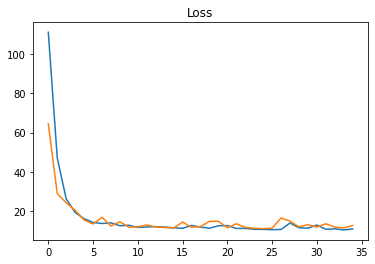

In [100]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [101]:
model.load_weights('best_model.hdf5')
model.save('nn_final.hdf5')

In [102]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 10.88%


In [103]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blending

In [104]:
blend_predict = (test_predict_catboost[:, 0] +
                 predict_dense[:, 0] + test_predict_nn3[:, 0]) / 3
print(f"TEST mape: {(MAPE_score(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.32%


In [104]:
blend_sub_predict = (sub_predict_catboost[:, 0] +
                     sub_predict_nn1[:, 0] + sub_predict_nn3[:, 0]) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False

<h>Результаты работы.
Улучшение безлайна, за счет:</h>
1.   Тщательно проведенного EDA
2.   Изменение архитектур
1.   Добавление шедулера для изменения лернинг рейта.






<h>Что можно сделать еще</h>
1.   Вытащить признаки из description
2.   Попробовать разные предобработки для description
1.   Использовать более сложные архитектуры для картинок